# IMDb Sentiment Analysis with Bidirectional LSTM

This notebook builds a sentiment classifier for IMDb movie reviews using TensorFlow/Keras. We walk through loading the dataset, preparing padded sequences, training a bidirectional LSTM, and evaluating performance.

**Pipeline overview**

1. Setup and imports  
2. Load and inspect the IMDb dataset  
3. Preprocess sequences with padding and exploratory checks  
4. Train a bidirectional LSTM baseline  
5. Evaluate accuracy and error patterns, then outline next steps

Dataset: TensorFlow/Keras IMDb reviews (25k train / 25k test) with integer-encoded tokens sorted by frequency.


## 1. Setup and Imports

Configure core libraries, reproducibility seeds, and training hyperparameters used throughout the workflow.


In [25]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Check working directory
print(f"Working directory: {os.getcwd()}")

Working directory: c:\Users\asus\OneDrive - Universidade de Aveiro\Documents\GitHub\RNN_Practicise_exercises-solution


## 2. Load

Download the IMDb movie-review dataset limited to the `NUM_WORDS=10000` most frequent tokens.

In [3]:
# Hyperparameter
NUM_WORDS = 10000        # keep the top-N most frequent tokens

#Load the IMDb dataset
(x_train_raw, y_train), (x_test_raw, y_test) = imdb.load_data(num_words=NUM_WORDS, index_from=3)

### 2.1 Inspect the data

This section helps understanding and verifying the data before feeding it into the neural network.
* Confirms dataset size;

* Reconstructs the word dictionary;

* Makes numeric reviews human-readable;

* Displays example reviews and labels;

* Checks that classes are balanced.



In [4]:
# Print the number of training and test samples (with thousands separator)
print(f"Training samples: {len(x_train_raw):,}")
print(f"Test samples: {len(x_test_raw):,}")

# -------------------------------------------------------------
# Build a reverse dictionary for the IMDb dataset (word <-> index)
# -------------------------------------------------------------

# Load the original word-index mapping (word → integer)
word_index = imdb.get_word_index()

# Shift all indices by +3 to leave space for special tokens
word_index = {k: (v + 3) for k, v in word_index.items()}

# Add reserved tokens used in the dataset
word_index['<PAD>'] = 0      # Padding token (used to fill shorter sequences)
word_index['<START>'] = 1    # Marks the beginning of a review
word_index['<UNK>'] = 2      # Unknown word (not in vocabulary)
word_index['<UNUSED>'] = 3   # Reserved for potential future use

# Create a reversed dictionary (index → word) for decoding reviews
reverse_word_index = {value: key for key, value in word_index.items()}

# -------------------------------------------------------------
# Function to convert a sequence of integers back into words
# -------------------------------------------------------------
def decode_review(sequence):
    # Replace each integer with its corresponding word, or '?' if not found
    return ' '.join(reverse_word_index.get(i, '?') for i in sequence)

# -------------------------------------------------------------
# Create a label map for sentiment categories
# -------------------------------------------------------------
label_map = {0: 'negative', 1: 'positive'}

# -------------------------------------------------------------
# Print an example decoded review and its sentiment label
# -------------------------------------------------------------
print("Example decoded review:")
print(decode_review(x_train_raw[0])[:500], "...")   # Show first 500 characters
print(f"Label: {label_map[y_train[0]]}")

# -------------------------------------------------------------
# Display the class distribution in the training data
# -------------------------------------------------------------
class_distribution = pd.Series(y_train).value_counts().sort_index()
print("Class distribution (train):")
print(class_distribution.rename(index=label_map))



Training samples: 25,000
Test samples: 25,000
Example decoded review:
<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would re ...
Label: positive
Class distribution (train):
negative    12500
positive    12500
Name: count, dtype: int64


## 3. Preprocess: Padding

Pad each review to `MAX_LEN=100` tokens to obtain fixed-length tensors and inspect raw-length statistics to justify the padding choice.


In [6]:
# Hyperparameter
## Maximum review length: each review will have 100 words (tokens)
## Reviews longer than this are truncated; shorter ones are padded with zeros.
MAX_LEN = 100 

# Pad or truncate the training sequences
x_train = pad_sequences(
    x_train_raw,
    maxlen=MAX_LEN,     # fixed sequence length (100)
    padding='post',     # add zeros at the end of short sequences
    truncating='post'   # cut extra words from the end of long sequences)
)

# Pad or truncate the test sequences using the same parameters
x_test = pad_sequences(
    x_test_raw,
    maxlen=MAX_LEN,
    padding='post',
    truncating='post',
)

# Print the resulting shapes after padding
print(f"x_train shape: {x_train.shape}")  # (num_train_samples, 100)
print(f"x_test shape: {x_test.shape}")    # (num_test_samples, 100)


x_train shape: (25000, 100)
x_test shape: (25000, 100)


## 4. Build the Bidirectional LSTM Model

Stack an embedding layer with a bidirectional LSTM to capture contextual information from both directions, then pool and classify with dense layers.


In [32]:
# -------------------- Model Definition --------------------
model = Sequential([
    tf.keras.layers.Input(shape=(MAX_LEN,)),  # 100 words per review
    tf.keras.layers.Embedding(input_dim=NUM_WORDS, output_dim=16, mask_zero=True),

    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(
        units=8,                # smaller LSTM (faster)
        return_sequences=True,
        dropout=0.2,
        recurrent_dropout=0.2
    )),
    
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# -------------------- Compilation --------------------
optimizer = Adam(learning_rate=5e-4)  # slightly higher LR to converge faster
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

C:\Users\asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\layer.py:970: UserWarning: Layer 'global_max_pooling1d_11' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)        │ (None, 100, 16)        │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ (None, 100, 16)        │         1,600 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_11         │ (None, 16)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 161,745 (631.82 KB)

 Trainable params: 161,745 (631.82 KB)

 Non-trainable params: 0 (0.00 B)

## 5. Train the Model

Fit the network with early stopping on validation accuracy to reduce overfitting.


In [34]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

history = model.fit(
    x_train,
    y_train,
    epochs=6,                # short training
    batch_size=128,          # faster per epoch
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1                # Display progress bars
)



Epoch 1/6
157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 100ms/step - accuracy: 0.6122 - loss: 0.6668 - val_accuracy: 0.7722 - val_loss: 0.5969
Epoch 2/6
157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 100ms/step - accuracy: 0.7296 - loss: 0.5779 - val_accuracy: 0.7864 - val_loss: 0.5234
Epoch 3/6
157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 101ms/step - accuracy: 0.7883 - loss: 0.4922 - val_accuracy: 0.8016 - val_loss: 0.4495
Epoch 4/6
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 99ms/step - accuracy: 0.8342 - loss: 0.4154 - val_accuracy: 0.8152 - val_loss: 0.4114
Epoch 5/6
157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 99ms/step - accuracy: 0.8676 - loss: 0.3569 - val_accuracy: 0.8226 - val_loss: 0.3913
Epoch 6/6
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 97ms/step - accuracy: 0.8777 - loss: 0.3240 - val_accuracy: 0.8296 - val_loss: 0.3828


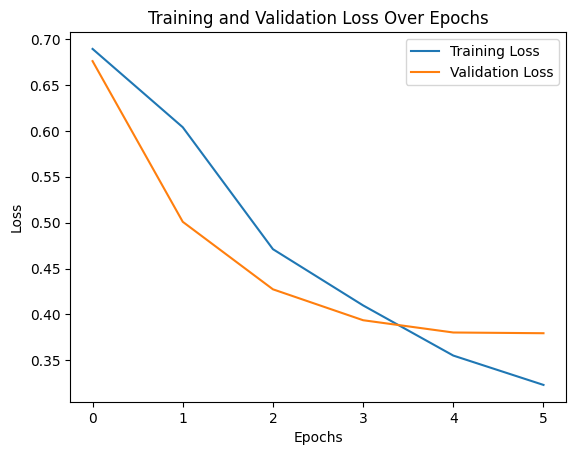

In [31]:
# Draw the training diagnostics loss curve
plt.plot(history.history['loss']) # Plotting training loss
plt.plot(history.history['val_loss']) # Plotting validation loss
plt.title("Training and Validation Loss Over Epochs") # Adding title
plt.xlabel("Epochs") # Adding x-axis label
plt.ylabel("Loss") # Adding y-axis label
plt.legend(["Training Loss", "Validation Loss"])
plt.show() # Displaying the plot

## 6. Evaluate and Interpret Results

After training, the model’s performance is assessed on the test set to verify its ability to generalize to unseen data.
Besides the loss and accuracy metrics automatically tracked during training, a more detailed analysis is carried out using additional classification metrics such as MAE, MSE and R2.

These metrics provide a clearer understanding of how well the model distinguishes between positive and negative reviews, complementing the overall accuracy measure.

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


# Predict
y_pred = model.predict(x_test)

# Compute metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")



## Next Steps

- Explore alternative model architectures (stacked LSTMs, GRUs, or convolutional front-ends) 
- Increase `NUM_WORDS` or `MAX_LEN` and observe the trade-off between vocabulary coverage and training cost.
- Add regularisation such as dropout, or incorporate pre-trained word embeddings (e.g., GloVe) for richer representations.
